# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 36

**Author 1 (sciper):** Ke Wang (326760)  
**Author 2 (sciper):** Jiaan Zhu (325421)   
**Author 3 (sciper):** Rémy Dornier (271174) 

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

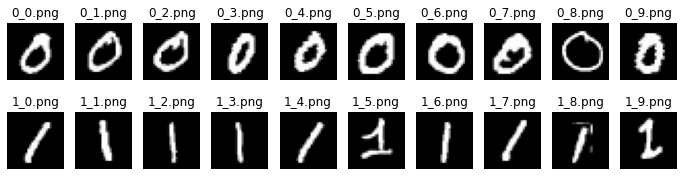

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit = '0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im_raw, zeros_names = load(data_part1, digit = '0')
ones_im_raw, ones_names = load(data_part1, digit = '1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im_raw), figsize = (12, 3))
for ax, im, nm in zip(axes[0], zeros_im_raw, zeros_names):
    ax.imshow(im, cmap = 'gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im_raw, ones_names):
    ax.imshow(im, cmap = 'gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

#### "fourier_descriptor" fonction.
 
 Computes the fourier descriptors according to the lecture's formula.
 It performs the rotation invariance by taking the modulus of the fourier descriptor and the scaling invariance by
 dividing by the energy. We decide to not include the 0th order fourier descriptor in the energy because it contains the DC part of the contour and therefore can bias the result and cannot ensure the translation invariance.
 
 #### inputs
 
    - contour : shape contour defined by successive [x,y] coordinate from the top left corner of the shape


 #### outputs
 
    - cont_dft : complex fourier descriptors (without any invariance normalization)
    - cont_dft_amp / energy : fourier descriptors with scaling and rotation invariance
    - energy : contour energy

In [3]:
def fourier_descriptor(contour):

    contour = contour.reshape(-1,2)
    cont_complex = list(map(lambda x: x[0] + x[1] * 1j, contour))                # transverse the cordinates to complex numbers
    cont_dft = np.fft.fft(cont_complex)                                          # dft
    cont_dft_amp = list(map(lambda x: np.sqrt(x.real**2 + x.imag**2), cont_dft)) # calculate amplitude of dft
    energy = np.sqrt(sum(pow(cont_dft_amp[i + 1],2) for i in range(len(cont_dft_amp) - 1))) # calculate energy
    
    return cont_dft, cont_dft_amp / energy, energy

#### "find_larger_blob" fonction. 

Keep the largest blob among every other ones found in the image.
 
#### input
 
    img : original image

#### output
 
    mask : image with the largest blob

In [4]:
def find_larger_blob(img):
    img_new = img.copy()
    
    # get connected components and statistics
    labels = measure.label(img_new)
    stats = measure.regionprops(labels)
    area_max = -1
    
    # find the largest blob
    for i in range(len(stats)):
        if stats[i].area > area_max:
            area_max = stats[i].area
            max_blob = i
    
    # put the largest blob on an image
    mask = np.zeros(img_new.shape)
    mask[labels == stats[max_blob].label] = 1
    
    return mask

 #### "outilne_image" fonction.  
 
 Performs the fourier description of the object contour starting with an 8-bits image.
 A first binarization is performed to deal with binary images.
 Then, a skeletonization step is done to thin the shape. Because some twos and threes images have closed loops, 
 it is necessary to apply a filling hole algorithm to fill these loops.
 Outlines are set on the largest binary shape found on the image by subtracting a dilated version to the skeltonized image.
 
 #### inputs
 
    imgs : original image
    bin_t : binary threshold

 #### outputs
 
    bin_img : thresholded image
    bin_outline : outline of the shape

In [5]:
def outline_image(imgs, bin_t):
    img = imgs.copy()
    
    # thresholding
    img[img > bin_t] = 255
    img[img <= bin_t] = 0

    bin_img = img.copy()

    # skeletonization
    skel = skeletonize(img / 255)
    skel = skel.astype(np.uint8)
   
    # filling holes
    cv2.floodFill(skel, None, (0,0), 255)
    skel = cv2.bitwise_not(skel)
    skel[skel > 0] = 1
    
    # find the largest binary shape (remove noisy shapes that can be detected)
    skel = find_larger_blob(skel)
    skel = skel.astype(np.uint8)
    
    # outline the remaining shape
    b = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3));
    dilate = cv2.dilate(skel, b, borderType = cv2.BORDER_REFLECT);
    bin_outline = dilate - skel
    
    return bin_img, bin_outline

#### Preprocessing

Digit images are first binarized to deal with binary images. The threshold has been adatped to have well defined digit shapes.


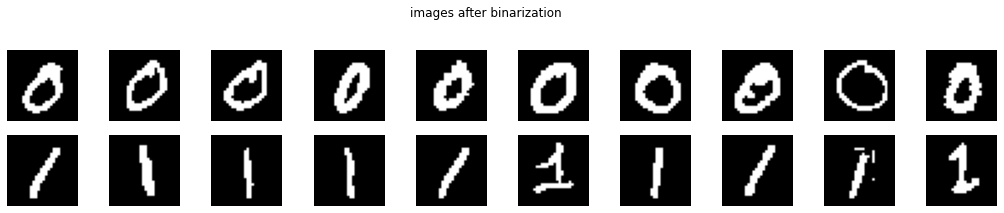

In [6]:
import cv2
import numpy as np

# binarization
bin_thresh = 100
ret, zeros_im = cv2.threshold(zeros_im_raw, bin_thresh, 255, cv2.THRESH_BINARY)
ret, ones_im = cv2.threshold(ones_im_raw, bin_thresh, 255, cv2.THRESH_BINARY)

# Plot images after binarization
plt.figure(figsize = (18,6))
plt.suptitle("images after binarization")
for i in range(len(zeros_im)):
    plt.subplot(4,10,i + 1)                                 
    plt.axis('off')
    plt.imshow(zeros_im[i], cmap = 'gray') 
for i in range(len(ones_im)):
    plt.subplot(4,10,i + len(zeros_im) + 1)
    plt.axis('off')
    plt.imshow(ones_im[i], cmap = 'gray')

#### Applying fourier description on digit contours

Contours are directly extracted from the binary images (succcesive pixels starting from the top-left pixel). Because many contours can be found, only the largest one is kept on each image. Finally, the fourier description is performed, under translation, rotation and scaling invariance. Results are presented below. 

Fourier descriptors are scaled by their energy and we graph the 2nd fourier descriptor in function of the 1st one. Doing that way, translation invariance is ensured. Results we got are nicely separable (2 classes) without any outliers.

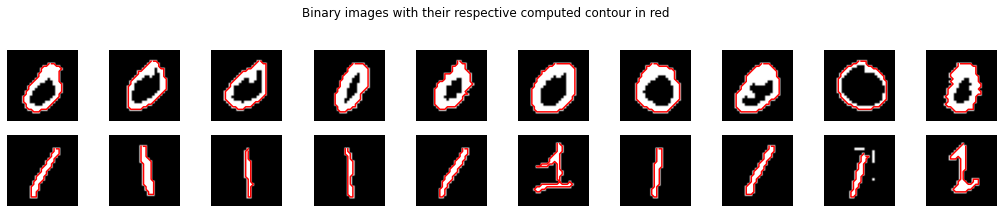

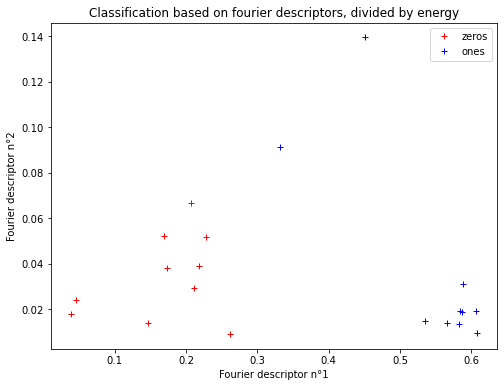

In [7]:
from skimage import measure
import math
from math import e
from skimage.morphology import skeletonize

# get the zeros and ones images
imgs = np.vstack((zeros_im, ones_im))

# initialization
fdx = 1
fdy = 2
fd1_scale = np.zeros((imgs.shape[0],1))
fd2_scale = np.zeros((imgs.shape[0],1))
contours_test = []

plt.figure(figsize = (18,6))
plt.suptitle("Binary images with their respective computed contour in red")

for i in range(imgs.shape[0]):
    img = imgs[i]
    
    # find shape contours
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # sort the contours by their area in descending order 
    area = []
    for cont in contours:
        area.append(cv2.contourArea(cont))
    area_descend = np.argsort(-np.array(area))
    max_area = area_descend[0]
    
    # compute fourier descriptor
    _, fd_scale, _ = fourier_descriptor(contours[max_area])

    plt.subplot(4,10,i + 1)                    
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')
    plt.plot(contours[max_area].reshape(-1,2)[:,0], contours[max_area].reshape(-1,2)[:,1], color = 'red')
    
    # keep only fourier descriptor fdx and fdy
    fd1_scale[i] = fd_scale[fdx]
    fd2_scale[i] = fd_scale[fdy]

# graph of fourier descriptor 1 and 2 for each image
plt.figure(figsize = (8,6))
plt.plot(fd1_scale[0:10], fd2_scale[0:10], color = 'r', linestyle = '', marker = '+', label = 'zeros')
plt.plot(fd1_scale[10:20], fd2_scale[10:20], color = 'b', linestyle = '', marker = '+', label = 'ones')
plt.legend(loc = 'upper right')
plt.xlabel('Fourier descriptor n°{}' .format(fdx))
plt.ylabel('Fourier descriptor n°{}' .format(fdy))
plt.title('Classification based on fourier descriptors, divided by energy')
plt.show()

 
 ### Fourier descriptor invariance
 
 Three types of invariance will be shown in the following.
 
     - translation : to be invariant to translation, the 0th fourier descriptor should be discarded because 
     it contains the DC part of the contour. Translation is coded in the contour DC part.
     
     - rotation : to be rotated invariant, the modulus of fourier descriptor should be taken instead of the real part. 
     Fourier descriptors are complex numbers ; the rotation affects the phase of the contour but the modulus remains 
     the same.
     
     - scaling : to be scaling invariant, fourier descriptors should divided by one of them (for exemple, divide 
     fourier descriptors by the 1st one). This will remove the scaling factor. It is also possible to divide them by the 
     contour energy, which is the way we are doing.


In [8]:
# get a set of images
imgs_for_invar = ones_im.copy()

# variables initialization
translation_factor = 2
scaling_factor = 2
affine_trans_matrix = np.float32([[1,0,translation_factor],[0,1,0]])
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3));
fd0_label = 0
fd1_label = 1
fd2_label = 2
fd3_label = 3

# fourier descriptor arrays initialization
fd0_arr = np.zeros((imgs_for_invar.shape[0] * 4, 1)).astype(complex)
fd1_arr = np.zeros((imgs_for_invar.shape[0] * 4, 1)).astype(complex)
fd2_arr = np.zeros((imgs_for_invar.shape[0] * 4, 1)).astype(complex)
energy_arr = np.zeros((imgs_for_invar.shape[0] * 4, 1))

for i in range(imgs_for_invar.shape[0]):
    # get an image
    img = imgs_for_invar[i]
    
    # performs rotation and translation on the binary image
    img_rot = np.flip(np.transpose(img), axis = 1)
    img_trans = cv2.warpAffine(img, affine_trans_matrix, img.shape)

    # stack the orignal outline image with the rotated and translated one
    imgs = np.dstack((img, img_trans))
    imgs = np.dstack((imgs, img_rot))
    
    for j in range(imgs.shape[2]):
        # find the shape contour from the oringinal/rotated/translated image
        contours, hierarchy = cv2.findContours(imgs[:,:,j], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
           
        # sort the contours by their area in descending order 
        area = []
        for cont in contours:
            area.append(cv2.contourArea(cont))
        area_descend = np.argsort(-np.array(area))
        max_area = area_descend[0]
    
        # compute fourier descriptor of the contour
        fd, _, energy = fourier_descriptor(contours[max_area])
        fd0_arr[i * 4 + j] = fd[fd0_label]
        fd1_arr[i * 4 + j] = fd[fd1_label]
        fd2_arr[i * 4 + j] = fd[fd2_label]
        energy_arr[i * 4 + j] = energy
    
    # procedure for scaling invariance
    # find the shape contour from the oringinal image 
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
           
    # sort the contours by their area in descending order 
    area = []
    for cont in contours:
        area.append(cv2.contourArea(cont))
    area_descend = np.argsort(-np.array(area))
    max_area = area_descend[0]
    
    # compute fourier descriptor of the scaled contour
    fd, _, energy = fourier_descriptor(contours[max_area] * scaling_factor)
    fd0_arr[i * 4 + 3] = fd[fd0_label]
    fd1_arr[i * 4 + 3] = fd[fd1_label]
    fd2_arr[i * 4 + 3] = fd[fd2_label]
    energy_arr[i * 4 + 3] = energy

#### Translation invariance

Translation invariance is perfomed of a shifted version of the original binary image (the one resulting after the pre-processing step). The 0th fourier descriptor encodes for translation. Thus, not taking it as a feature will ensure the translation invariance as showing in the 2 following plots. On both plots, since fourier descriptors are complex numbers, data points correspond to the real part of each fourier descriptor. Of course, the invariance to translation can also be demonstrated if taking the modulus of the fourier descriptor.

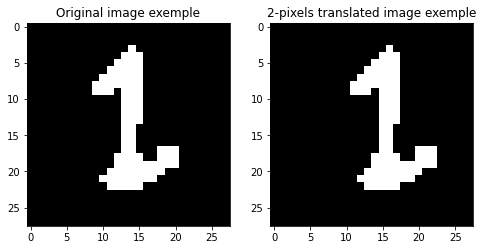

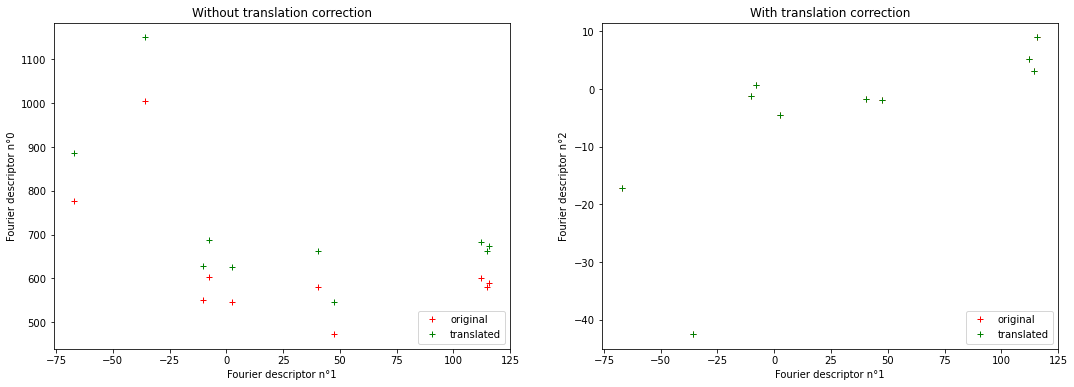

In [9]:
# plot images (original and translated version)
plt.figure(figsize = (8,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title('Original image exemple')
plt.subplot(1,2,2)
plt.imshow(img_trans, cmap = 'gray')
plt.title('2-pixels translated image exemple')

# plot fourier descriptors (without correction)
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.xlabel('Fourier descriptor n°{}' .format(fd1_label))
plt.ylabel('Fourier descriptor n°{}' .format(fd0_label))
plt.title('Without translation correction')
plt.plot(np.real(fd1_arr[0::4]), np.real(fd0_arr[0::4]), color = 'r', linestyle = '', marker = '+', label = 'original')
plt.plot(np.real(fd1_arr[1::4]), np.real(fd0_arr[1::4]), color = 'g', linestyle = '', marker = '+', label = 'translated')
plt.legend(loc = 'lower right')

# plot fourier descriptors (with correction)
plt.subplot(1,2,2)
plt.xlabel('Fourier descriptor n°{}' .format(fd1_label))
plt.ylabel('Fourier descriptor n°{}' .format(fd2_label))
plt.title('With translation correction')
plt.plot(np.real(fd1_arr[0::4]), np.real(fd2_arr[0::4]), color = 'r', linestyle = '', marker = '+', label = 'original')
plt.plot(np.real(fd1_arr[1::4]), np.real(fd2_arr[1::4]), color = 'g', linestyle = '', marker = '+', label = 'translated')
plt.legend(loc = 'lower right')
plt.show()

#### Rotation invariance

Rotation invariance is perfomed of a 90° rotated version of the original binary image (the one resulting after the pre-processing step). Rotation only affects the contour's phase. On the left plot, the real part of the first and second fourier descriptor is taken whereas the modulus is computed for each of them on the right plot. As you can see, results for rotation are identical to the original when taking the modulus of fourier descriptors. The 0th order fourier descriptor is not graphed ; we only take the first and the second one. This is because even if we performed a pure rotation, a hidden translation operation is also performed.

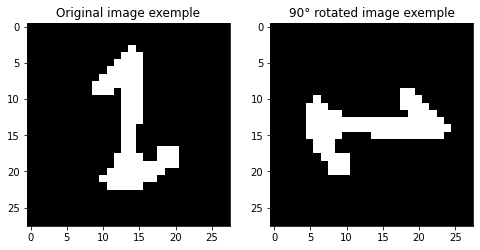

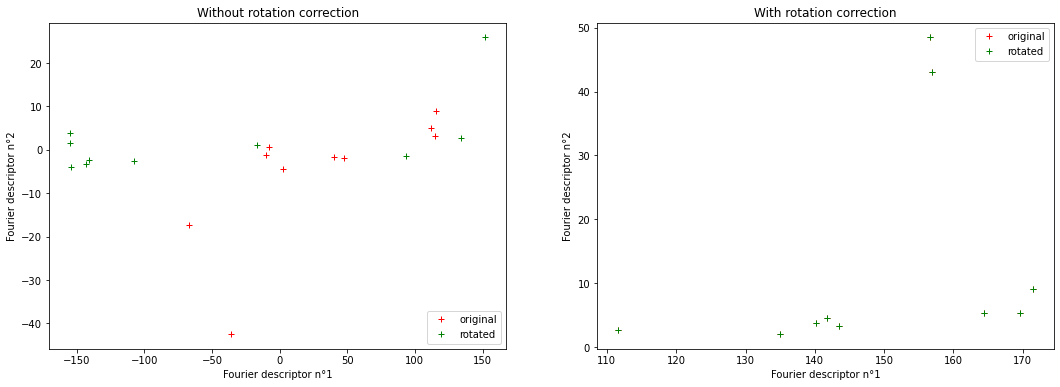

In [10]:
# plot images (original and rotated version)
plt.figure(figsize = (8,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title('Original image exemple')
plt.subplot(1,2,2)
plt.imshow(img_rot, cmap = 'gray')
plt.title('90° rotated image exemple')

# plot fourier descriptors (without correction)
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.xlabel('Fourier descriptor n°{}' .format(fd1_label))
plt.ylabel('Fourier descriptor n°{}' .format(fd2_label))
plt.title('Without rotation correction')
plt.plot(np.real(fd1_arr[0::4]), np.real(fd2_arr[0::4]), color = 'r', linestyle = '', marker = '+', label = 'original')
plt.plot(np.real(fd1_arr[2::4]), np.real(fd2_arr[2::4]), color = 'g', linestyle = '', marker = '+', label = 'rotated')
plt.legend(loc = 'lower right')

# plot fourier descriptors (with correction)
plt.subplot(1,2,2)
plt.xlabel('Fourier descriptor n°{}' .format(fd1_label))
plt.ylabel('Fourier descriptor n°{}' .format(fd2_label))
plt.title('With rotation correction')
plt.plot(abs(fd1_arr[0::4]), abs(fd2_arr[0::4]), color = 'r', linestyle = '', marker = '+', label = 'original')
plt.plot(abs(fd1_arr[2::4]), abs(fd2_arr[2::4]), color = 'g', linestyle = '', marker = '+', label = 'rotated')
plt.legend(loc = 'upper right')
plt.show()

#### Scaling invariance

The scaling invariance is not perfomed on an image anymore, as it is the case for translation and rotation invariance. Because of sampling and contour length effects, we take the contour extracted from the original binary image and scale it by a factor 2. Fourier descriptors are then computed on the scaled version of the original contour. On the left plot, the modulus of fourier descriptors of the original and scaled contour are shown. On the right plot, we divided each fourier descriptor by its respective contour energy. This finally shows that dividing by the contour energy gets rid of the scaling factor.

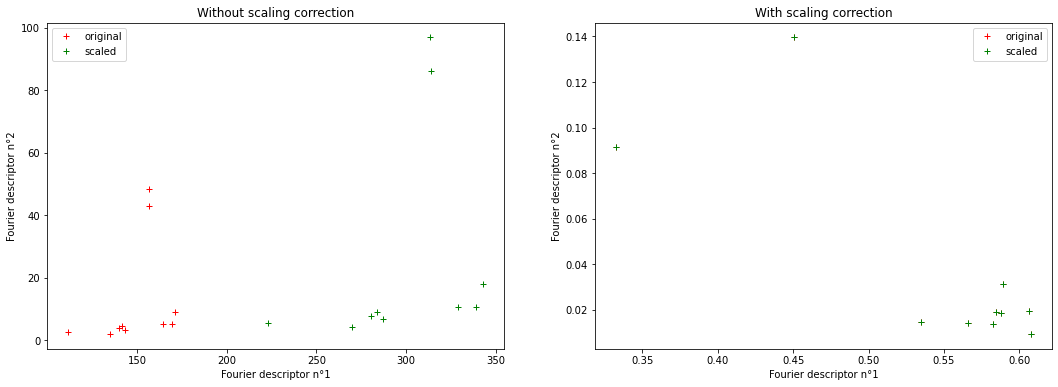

In [11]:
# plot fourier descriptors (without correction)
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.xlabel('Fourier descriptor n°{}' .format(fd1_label))
plt.ylabel('Fourier descriptor n°{}' .format(fd2_label))
plt.title('Without scaling correction')
plt.plot(abs(fd1_arr[0::4]), abs(fd2_arr[0::4]), color = 'r', linestyle = '', marker = '+', label = 'original')
plt.plot(abs(fd1_arr[3::4]), abs(fd2_arr[3::4]), color = 'g', linestyle = '', marker = '+', label = 'scaled')
plt.legend(loc = 'upper left')

# plot fourier descriptors (with correction)
plt.subplot(1,2,2)
plt.xlabel('Fourier descriptor n°{}' .format(fd1_label))
plt.ylabel('Fourier descriptor n°{}' .format(fd2_label))
plt.title('With scaling correction')
plt.plot(abs(fd1_arr[0::4]) / energy_arr[0::4], abs(fd2_arr[0::4]) / energy_arr[0::4], color = 'r', linestyle = '', marker = '+', label = 'original')
plt.plot(abs(fd1_arr[3::4]) / energy_arr[3::4], abs(fd2_arr[3::4]) / energy_arr[3::4], color = 'g', linestyle = '', marker = '+', label = 'scaled')
plt.legend(loc = 'upper right')
plt.show()

### 1.3 Additional method (5 pts)

 The additional method chosen here is a blob-based method. The previously computed outline images are filled to be 
 transformed into blobs. Some statistical parameters, named features, are computed on such blobs. Based on that
 features, it is possible to nicely separate the "zeros" from the "ones", as shown in the next plot.
 
 Here, the elongation feature and solidity feature are extracted.
 
    - Elongation : it is the ratio between the maximum diameter of the object and the minimum diameter in the 
      perpendicular direction.
      
    - Solidity : defines how well the blob can be approximated by a geometric structure. 
      It is the ratio between the blob area and the convex area (of the geometric shape that includes the blob).

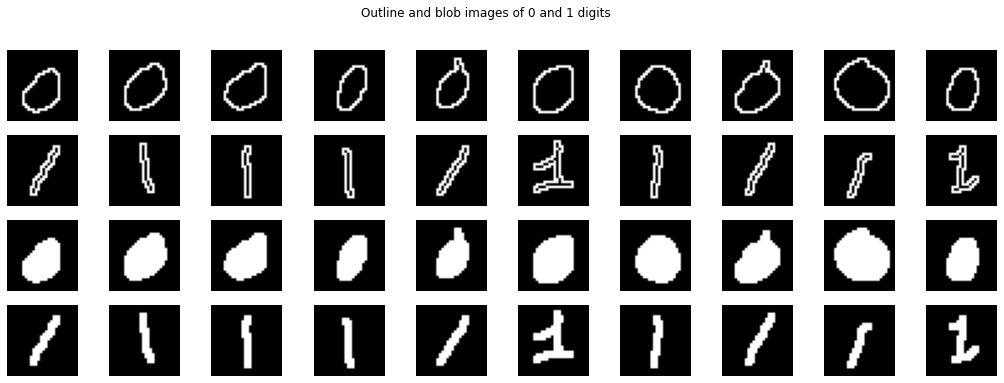

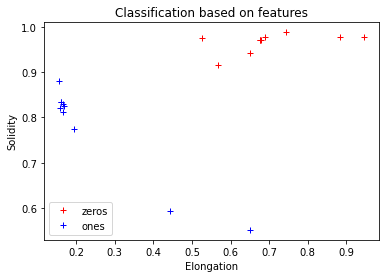

In [12]:
# initialization
imgs = np.vstack((zeros_im_raw, ones_im_raw))
bin_t = 120
feature1 = np.zeros((imgs.shape[0], 1))
feature2 = np.zeros((imgs.shape[0], 1))

plt.figure(figsize = (18,6))
plt.suptitle("Outline and blob images of 0 and 1 digits")
for i in range(imgs.shape[0]):
    img = imgs[i].copy()
    
    # get image outlines
    img, outline = outline_image(img, bin_t)
    
    plt.subplot(4,10,i + 1)
    plt.axis('off')
    plt.imshow(outline, cmap = 'gray')
    
    # fill contours holes
    blob = outline.copy()
    cv2.floodFill(blob, None, (0,0), 255)
    blob = cv2.bitwise_not(blob)
    blob[blob > 0] = 255
    
    plt.subplot(4,10,i + 21)
    plt.axis('off')
    plt.imshow(blob, cmap = 'gray')

    # find the largest binary shape (remove noisy shapes that can be detected)
    img = find_larger_blob(blob)
    
    # get connected components
    labels = measure.label(img)
    stats = measure.regionprops(labels)
    
    # compute features
    feature1[i] = stats[0].minor_axis_length / stats[0].major_axis_length
    feature2[i] = stats[0].solidity

# plot features for each image
plt.figure()
plt.plot(feature1[0:10], feature2[0:10], color = 'r', linestyle = '', marker = '+', label = 'zeros')
plt.plot(feature1[10:20], feature2[10:20], color = 'b', linestyle = '', marker = '+', label = 'ones')
plt.legend(loc = 'lower left')
plt.xlabel('Elongation')
plt.ylabel('Solidity')
plt.title('Classification based on features')
plt.show()

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

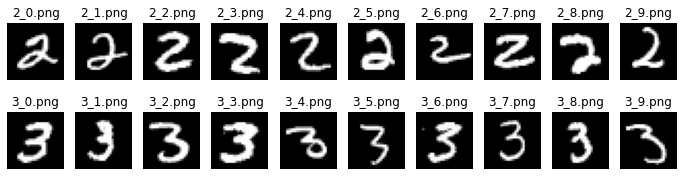

In [13]:
#  Load twos and threes
twos_im_raw, twos_names = load(data_part2, digit = '2')
threes_im_raw, threes_names = load(data_part2, digit = '3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im_raw), figsize = (12, 3))
for ax, im, nm in zip(axes[0], twos_im_raw, twos_names):
    ax.imshow(im, cmap = 'gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im_raw, threes_names):
    ax.imshow(im, cmap = 'gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In this part, we reuse the code of the first part to compute fourier descriptors of "twos" and "threes" digits. Binarization is used as the pre-processing step, with the same threshold. 

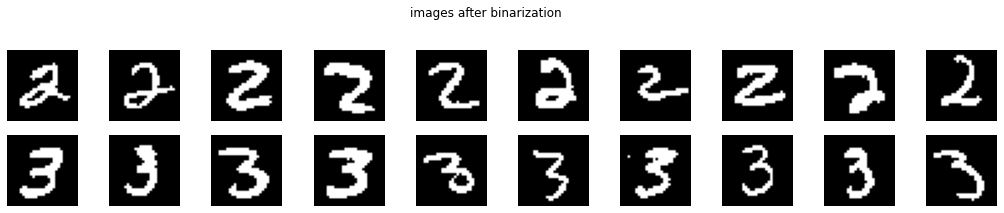

In [14]:
# binarization
bin_thresh = 100
ret, twos_im = cv2.threshold(twos_im_raw, bin_thresh, 255, cv2.THRESH_BINARY)
ret, threes_im = cv2.threshold(threes_im_raw, bin_thresh, 255, cv2.THRESH_BINARY)

# Plot images
plt.figure(figsize = (18,6))
plt.suptitle("images after binarization")
for i in range(len(twos_im)):
    plt.subplot(4,10,i + 1)                                 
    plt.axis('off')
    plt.imshow(twos_im[i], cmap = 'gray') 
for i in range(len(threes_im)):
    plt.subplot(4,10,i + len(twos_im) + 1)
    plt.axis('off')
    plt.imshow(threes_im[i], cmap = 'gray')

For fourier description, translation, rotation and scaling invariance are applied on the first and second fourier descriptors that we use as features. The results show that if it was possible to separate the "zeros" from the "ones", then, it is not so possible to separate the "twos" from the "threes" (right plot). We could find 2 classes but there will be outliers on each classes. When putting all together (left plot), it comes out that it is also not possible to completely separte them, except for the "zeros" class which is nicely separated from the other ones. The "ones" class could be reasonably separated if we accept to loose 2 "ones" outliers and get one "twos" outlier. This results probably come from the fact that 2 features is not enough to characterize each of the digit in a unique manner. In order to have them separated, we can think about a 3-features representation or may be apply another 2-features method.

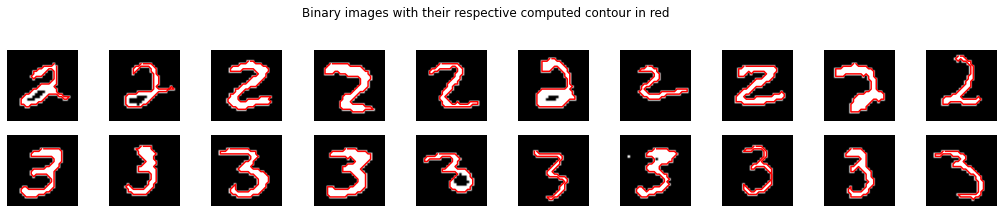

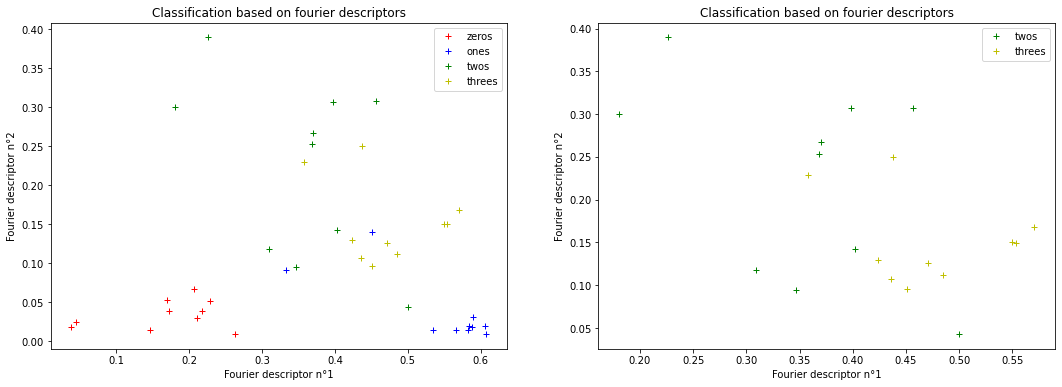

In [15]:
# Extract twos and threes images
imgs = np.vstack((twos_im, threes_im))

# initialization
plt.figure(figsize = (18,6))
plt.suptitle("Binary images with their respective computed contour in red")

fd3 = np.zeros((imgs.shape[0], 1))
fd4 = np.zeros((imgs.shape[0], 1))

for i in range(imgs.shape[0]):
    img = imgs[i] 
    
    # find shape contours
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # sort the contours by their area in descending order 
    area = []   
    for cont in contours:
        area.append(cv2.contourArea(cont))
    area_descend = np.argsort(-np.array(area))
    max_area = area_descend[0]
    
    # compute fourier descriptor
    _, fd_scale, _ = fourier_descriptor(contours[max_area]) 

    plt.subplot(4,10,i + 1)                                 
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')                    
    plt.plot(contours[max_area].reshape(-1,2)[:,0], contours[max_area].reshape(-1,2)[:,1], color = 'red')

    # keep only fourier descriptor fdx and fdy
    fd3[i] = fd_scale[fdx]         
    fd4[i] = fd_scale[fdy]                      

# plot fourier descriptors for each image
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.plot(fd1_scale[0:10], fd2_scale[0:10], color = 'r', linestyle = '', marker = '+', label = 'zeros') 
plt.plot(fd1_scale[10:20], fd2_scale[10:20], color = 'b', linestyle = '', marker = '+', label = 'ones') 
plt.plot(fd3[0:10], fd4[0:10], color = 'g', linestyle = '', marker = '+', label = 'twos')
plt.plot(fd3[10:20], fd4[10:20], color = 'y', linestyle = '', marker = '+', label = 'threes')
plt.legend(loc = 'upper right')
plt.xlabel('Fourier descriptor n°{}'.format(fdx))
plt.ylabel('Fourier descriptor n°{}'.format(fdy))
plt.title('Classification based on fourier descriptors')

plt.subplot(1,2,2)
plt.plot(fd3[0:10], fd4[0:10], color = 'g', linestyle = '', marker = '+', label = 'twos')
plt.plot(fd3[10:20], fd4[10:20], color = 'y', linestyle = '', marker = '+', label = 'threes')
plt.legend(loc = 'upper right')
plt.xlabel('Fourier descriptor n°{}'.format(fdx))
plt.ylabel('Fourier descriptor n°{}'.format(fdy))
plt.title('Classification based on fourier descriptors')
plt.show()

#### Optional Other method : Same as the additional method in the part 1 (based on blob statistics)

"Twos" and "threes" are here transformed into blob (as "zeros" and "ones" in the first part) and the same statistical parameters are computed. Results are presented below. What we can see here is that, if it was possible to separate the "zeros" from the "ones", then, it is more difficult to separate the "twos" from the "threes" (as for the fourier descriptors, classes will have outliers). When putting all together (left plot), it comes out that it is possible to nicely separte three classes : "zeros", "ones" and a last one with "threes" and "twos" together with 2 "ones" outliers in the "twos"/"threes" class. Of course, it is possible to found 4 classes but the accuracy on "threes" and "twos" is smaller. The same conclusion as above can be drawn here, regarding the number of features which is too low.

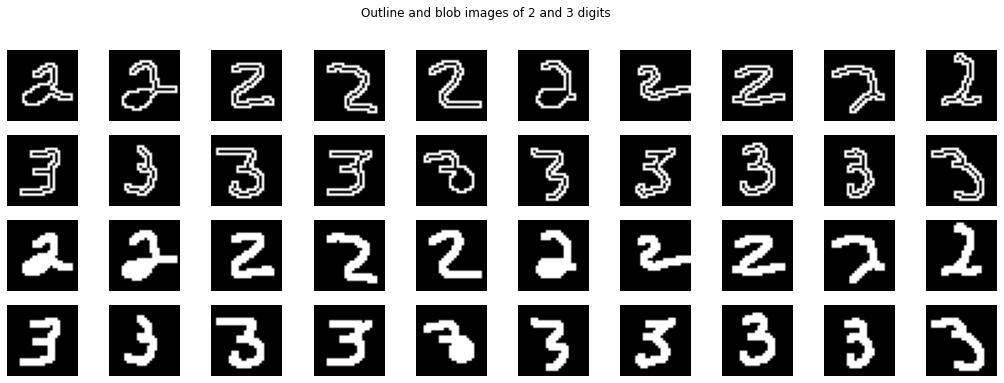

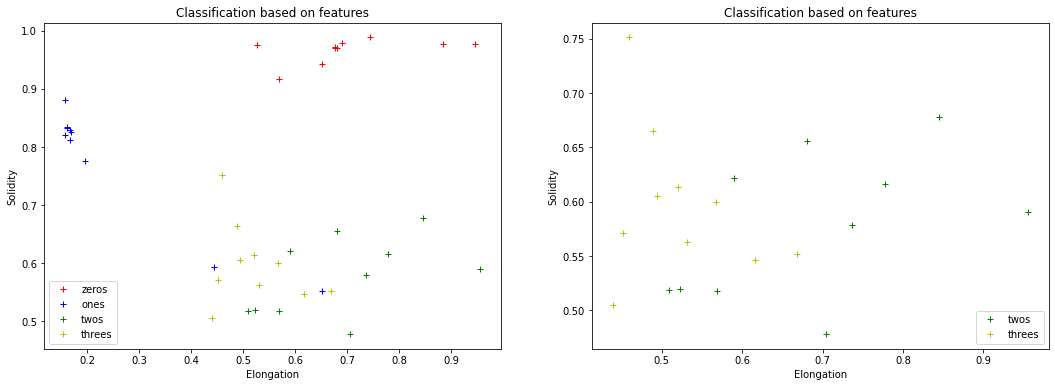

In [16]:
# initialization
imgs = np.vstack((twos_im_raw, threes_im_raw))
bin_t = 120
feature3 = np.zeros((imgs.shape[0], 1))
feature4 = np.zeros((imgs.shape[0], 1))

plt.figure(figsize = (18,6))
plt.suptitle("Outline and blob images of 2 and 3 digits")
for i in range(imgs.shape[0]):
    img = imgs[i].copy()
    
    # find image outlines
    img,outline = outline_image(img, bin_t)

    plt.subplot(4,10,i + 1)
    plt.axis('off')
    plt.imshow(outline, cmap = 'gray')
    
    # fill contour holes
    blob = outline.copy()
    cv2.floodFill(blob, None, (0,0), 255)
    blob = cv2.bitwise_not(blob)
    blob[blob > 0] = 255

    plt.subplot(4,10,i + 21)
    plt.axis('off')
    plt.imshow(blob, cmap = 'gray')

    # find the largest binary shape (remove noisy shapes that can be detected)
    img = find_larger_blob(blob)
    
    # get connected components
    labels = measure.label(img)
    stats = measure.regionprops(labels)
    
    # compute features
    feature3[i] = stats[0].minor_axis_length / stats[0].major_axis_length
    feature4[i] = stats[0].solidity

# plot features for each image
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.plot(feature1[0:10], feature2[0:10], color = 'r', linestyle = '', marker = '+', label = 'zeros')
plt.plot(feature1[10:20], feature2[10:20], color = 'b', linestyle = '', marker = '+', label = 'ones')
plt.plot(feature3[0:10], feature4[0:10], color = 'g', linestyle = '', marker = '+', label = 'twos')
plt.plot(feature3[10:20], feature4[10:20], color = 'y', linestyle = '', marker = '+', label = 'threes')
plt.legend(loc = 'lower left')
plt.xlabel('Elongation')
plt.ylabel('Solidity')
plt.title('Classification based on features')

plt.subplot(1,2,2)
plt.plot(feature3[0:10], feature4[0:10], color = 'g', linestyle = '', marker = '+', label = 'twos')
plt.plot(feature3[10:20], feature4[10:20], color = 'y', linestyle = '', marker = '+', label = 'threes')
plt.legend(loc = 'lower right')
plt.xlabel('Elongation')
plt.ylabel('Solidity')
plt.title('Classification based on features')
plt.show()